In [3]:
import numpy as np
import pandas as pd
from datetime import datetime
import pm4py  # install pm4py using: pip install pm4py

# Load the XES event log
file_path = '/Users/mac/Desktop/10258_mobis_challenge_log_2019.xes'
event_log = pm4py.read_xes('/Users/mac/Desktop/10258_mobis_challenge_log_2019.xes')
df = pm4py.convert_to_dataframe(event_log)
print(df.head())

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/6555 [00:00<?, ?it/s]

         concept:name lifecycle:transition org:resource  \
0        pay expenses                start         FI12   
1        pay expenses             complete         FI12   
2        pay expenses                start       JH2172   
3        pay expenses             complete       JH2172   
4  calculate payments                start       WE5108   

             time:timestamp            activity    user case:concept:name  \
0 2017-01-16 13:29:00+00:00        pay expenses    FI12                 1   
1 2017-01-16 13:40:00+00:00        pay expenses    FI12                 1   
2 2017-01-16 08:38:00+00:00        pay expenses  JH2172                 5   
3 2017-01-16 08:48:00+00:00        pay expenses  JH2172                 5   
4 2017-01-04 06:59:00+00:00  calculate payments  WE5108                 6   

  case:variant  case:variant-index    case:creator  
0   Variant 10                  10  Fluxicon Disco  
1   Variant 10                  10  Fluxicon Disco  
2   Variant 10         

Mean Cumulative Execution Time before filter: 74266833.20121951
Standard Deviation of Cumulative Execution Time before filter: 32042112.414101433
Stability Score (Before Filtering): 100.00%


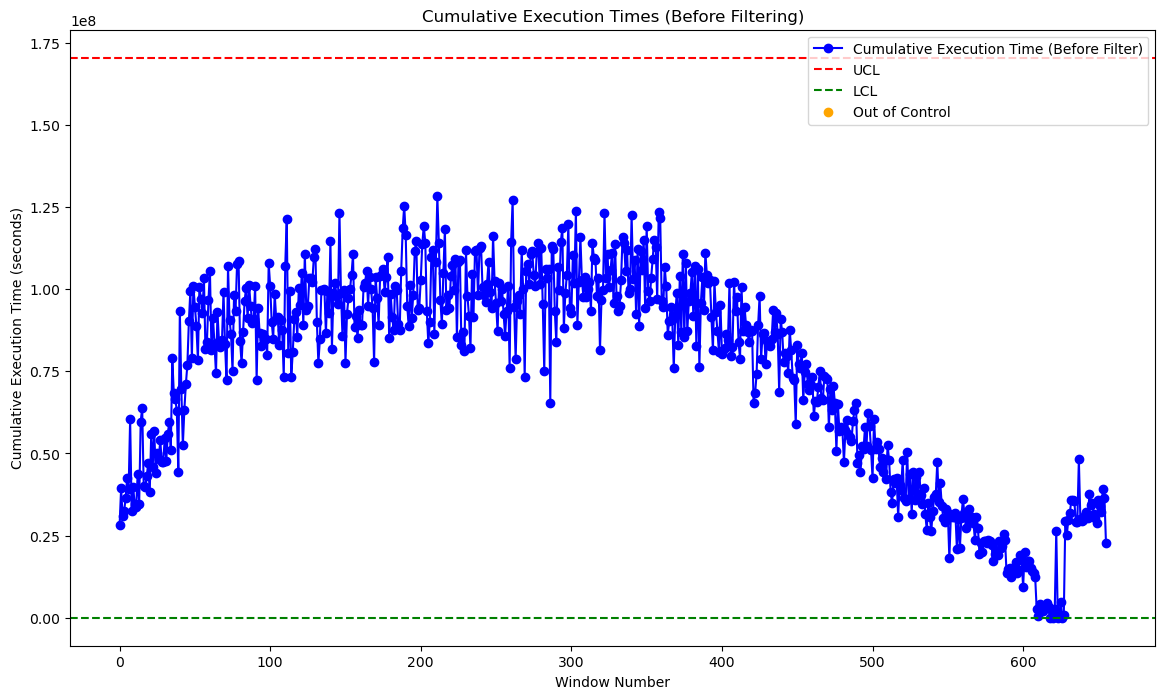

Stability Score (After Filtering): 100.00%


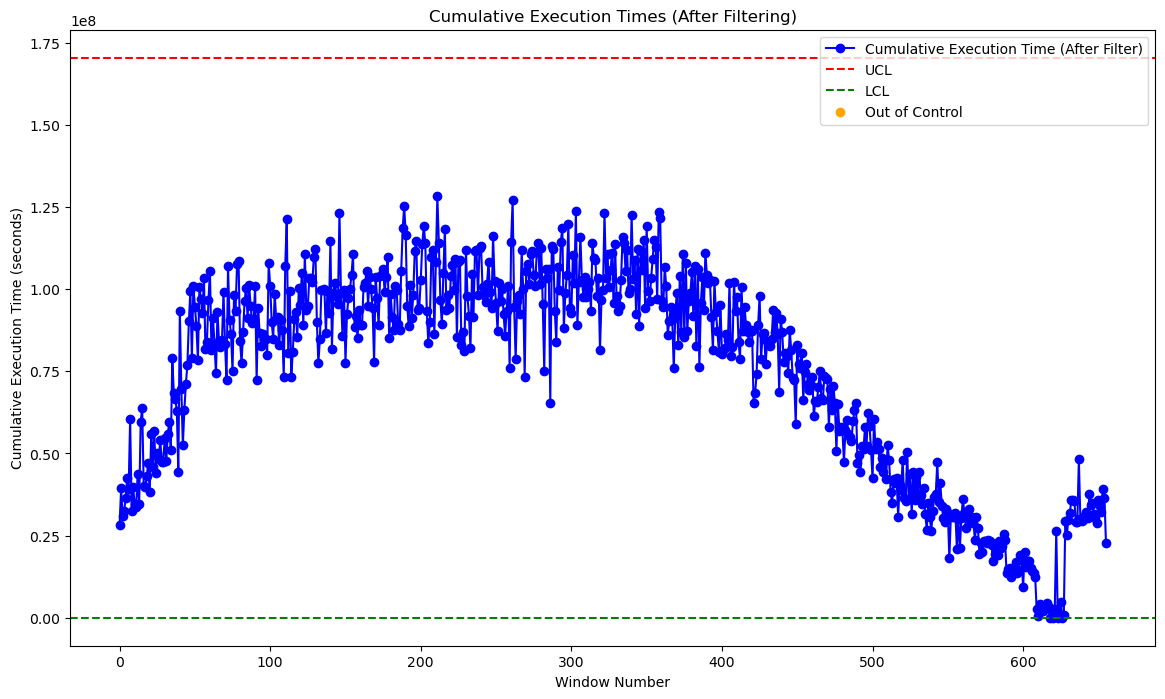

In [4]:
# apply 10 window 最终版 filter前后：
import pandas as pd
import matplotlib.pyplot as plt

# 假设数据已加载并转换为时间戳
df['Complete Timestamp'] = pd.to_datetime(df['time:timestamp'])

# Step 1: 计算每个 Case 的执行时间 (未过滤数据)
execution_time_before_filter = df.groupby('case:concept:name').apply(
    lambda x: (x['Complete Timestamp'].max() - x['Complete Timestamp'].min()).total_seconds()
).reset_index(name='Execution Time')

# Step 2: 计算每 10-case 窗口的累计执行时间
window_size = 10
execution_time_before_filter['Window Number'] = execution_time_before_filter.index // window_size
cumulative_execution_time_before_filter = execution_time_before_filter.groupby('Window Number')['Execution Time'].sum().reset_index(name='Cumulative Execution Time')

# Step 3: 计算累计执行时间的均值和标准差
mean_cumulative_time_before_filter = cumulative_execution_time_before_filter['Cumulative Execution Time'].mean()
std_cumulative_time_before_filter = cumulative_execution_time_before_filter['Cumulative Execution Time'].std()
print(f"Mean Cumulative Execution Time before filter: {mean_cumulative_time_before_filter}")
print(f"Standard Deviation of Cumulative Execution Time before filter: {std_cumulative_time_before_filter}")

# Step 4: 计算控制限
UCL_before_filter = mean_cumulative_time_before_filter + 3 * std_cumulative_time_before_filter
LCL_before_filter = max(mean_cumulative_time_before_filter - 3 * std_cumulative_time_before_filter, 0)

# Step 5: 标记超出控制限的窗口
cumulative_execution_time_before_filter['Out of Control'] = (cumulative_execution_time_before_filter['Cumulative Execution Time'] > UCL_before_filter) | \
                                                            (cumulative_execution_time_before_filter['Cumulative Execution Time'] < LCL_before_filter)

# Step 6: 打印稳定性分数
stability_score_before_filter = 1 - cumulative_execution_time_before_filter['Out of Control'].mean()
print(f"Stability Score (Before Filtering): {stability_score_before_filter:.2%}")

# Step 7: 绘制累计执行时间与控制限
plt.figure(figsize=(14, 8))
plt.plot(
    cumulative_execution_time_before_filter['Window Number'],
    cumulative_execution_time_before_filter['Cumulative Execution Time'],
    marker='o',
    linestyle='-',
    color='blue',
    label='Cumulative Execution Time (Before Filter)'
)
plt.axhline(UCL_before_filter, color='red', linestyle='--', label='UCL')
plt.axhline(LCL_before_filter, color='green', linestyle='--', label='LCL')
out_of_control_before_filter = cumulative_execution_time_before_filter['Out of Control']
plt.scatter(
    cumulative_execution_time_before_filter['Window Number'][out_of_control_before_filter],
    cumulative_execution_time_before_filter['Cumulative Execution Time'][out_of_control_before_filter],
    color='orange',
    label='Out of Control'
)
plt.title('Cumulative Execution Times (Before Filtering)')
plt.xlabel('Window Number')
plt.ylabel('Cumulative Execution Time (seconds)')
plt.legend()
plt.show()

# Step 1: 过滤掉执行时间为 0 的数据
execution_time_after_filter = execution_time_before_filter[execution_time_before_filter['Execution Time'] > 0]

# Step 2: 计算每 10-case 窗口的累计执行时间
execution_time_after_filter['Window Number'] = execution_time_after_filter.index // window_size
cumulative_execution_time_after_filter = execution_time_after_filter.groupby('Window Number')['Execution Time'].sum().reset_index(name='Cumulative Execution Time')

# Step 3: 计算累计执行时间的均值和标准差
mean_cumulative_time_after_filter = cumulative_execution_time_after_filter['Cumulative Execution Time'].mean()
std_cumulative_time_after_filter = cumulative_execution_time_after_filter['Cumulative Execution Time'].std()

# Step 4: 计算控制限
UCL_after_filter = mean_cumulative_time_after_filter + 3 * std_cumulative_time_after_filter
LCL_after_filter = max(mean_cumulative_time_after_filter - 3 * std_cumulative_time_after_filter, 0)

# Step 5: 标记超出控制限的窗口
cumulative_execution_time_after_filter['Out of Control'] = (cumulative_execution_time_after_filter['Cumulative Execution Time'] > UCL_after_filter) | \
                                                           (cumulative_execution_time_after_filter['Cumulative Execution Time'] < LCL_after_filter)

# Step 6: 打印稳定性分数
stability_score_after_filter = 1 - cumulative_execution_time_after_filter['Out of Control'].mean()
print(f"Stability Score (After Filtering): {stability_score_after_filter:.2%}")

# Step 7: 绘制累计执行时间与控制限
plt.figure(figsize=(14, 8))
plt.plot(
    cumulative_execution_time_after_filter['Window Number'],
    cumulative_execution_time_after_filter['Cumulative Execution Time'],
    marker='o',
    linestyle='-',
    color='blue',
    label='Cumulative Execution Time (After Filter)'
)
plt.axhline(UCL_after_filter, color='red', linestyle='--', label='UCL')
plt.axhline(LCL_after_filter, color='green', linestyle='--', label='LCL')
out_of_control_after_filter = cumulative_execution_time_after_filter['Out of Control']
plt.scatter(
    cumulative_execution_time_after_filter['Window Number'][out_of_control_after_filter],
    cumulative_execution_time_after_filter['Cumulative Execution Time'][out_of_control_after_filter],
    color='orange',
    label='Out of Control'
)
plt.title('Cumulative Execution Times (After Filtering)')
plt.xlabel('Window Number')
plt.ylabel('Cumulative Execution Time (seconds)')
plt.legend()
plt.show()

Before Filtering - Stability Score: 99.54%
Before Filtering - Unstable Windows: 3
Before Filtering - Stable Windows: 653


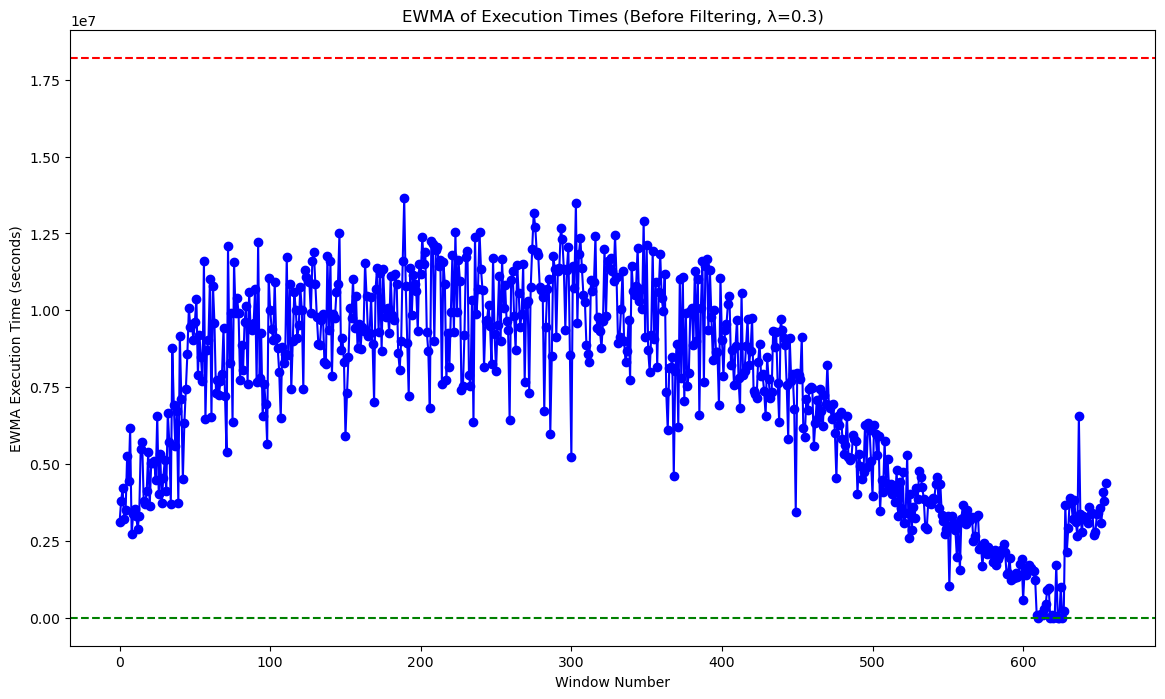

After Filtering - Stability Score: 99.54%
After Filtering - Unstable Windows: 3
After Filtering - Stable Windows: 653


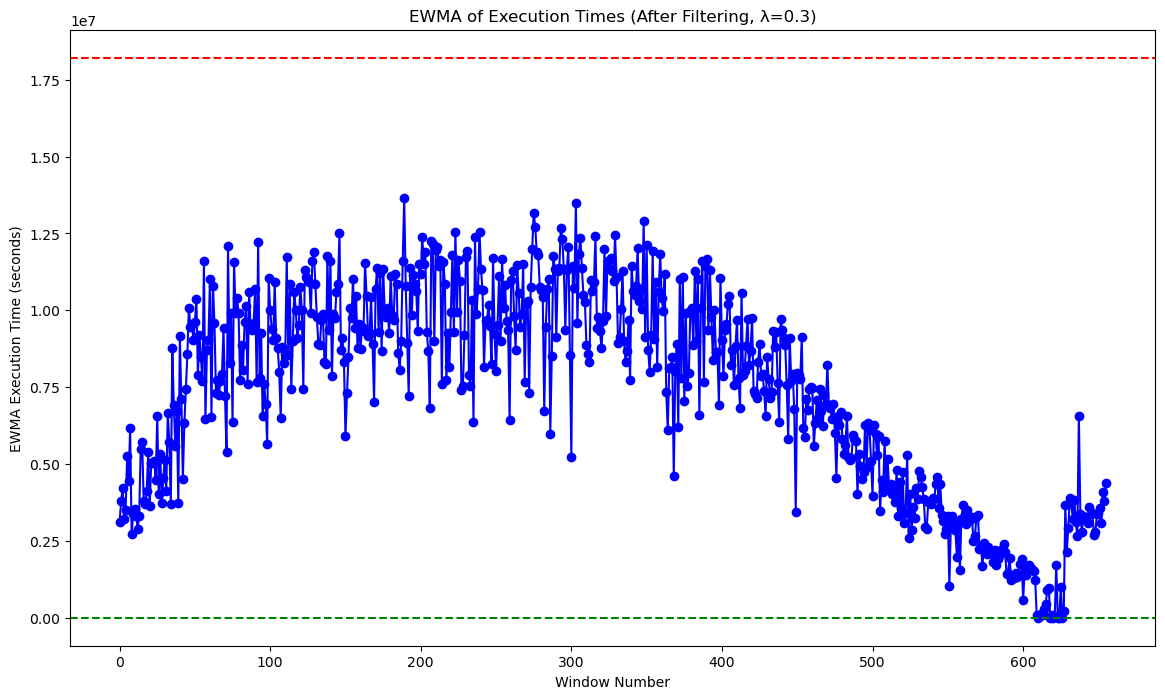

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# 设置 EWMA 平滑因子
lambda_ewma = 0.3

# 定义 EWMA 计算函数
def calculate_ewma(execution_times, lambda_ewma):
    ewma_values = []
    prev_ewma = execution_times[0]  # 使用第一个值初始化 EWMA
    for i in range(len(execution_times)):
        ewma = lambda_ewma * execution_times[i] + (1 - lambda_ewma) * prev_ewma
        ewma_values.append(ewma)
        prev_ewma = ewma
    return ewma_values

# Step 1: 计算每 10-case 窗口的 EWMA 值（过滤前数据）
execution_time_before_filter = df.groupby('case:concept:name').apply(
    lambda x: (x['Complete Timestamp'].max() - x['Complete Timestamp'].min()).total_seconds()
).reset_index(name='Execution Time')

window_size = 10
execution_time_before_filter['Window Number'] = execution_time_before_filter.index // window_size
ewma_results_before_filter = []

for _, window_data in execution_time_before_filter.groupby('Window Number'):
    ewma_values = calculate_ewma(window_data['Execution Time'].values, lambda_ewma)
    ewma_results_before_filter.extend(ewma_values)

execution_time_before_filter['EWMA'] = ewma_results_before_filter

# Step 2: 标记不稳定窗口（过滤前数据）
mean_ewma_before_filter = execution_time_before_filter['EWMA'].mean()
std_ewma_before_filter = execution_time_before_filter['EWMA'].std()
UCL_ewma_before_filter = mean_ewma_before_filter + 3 * std_ewma_before_filter
LCL_ewma_before_filter = max(mean_ewma_before_filter - 3 * std_ewma_before_filter, 0)

execution_time_before_filter['Out of Control'] = (execution_time_before_filter['EWMA'] > UCL_ewma_before_filter) | \
                                                 (execution_time_before_filter['EWMA'] < LCL_ewma_before_filter)

unstable_windows_before_filter = execution_time_before_filter.groupby('Window Number')['Out of Control'].any().sum()
stable_windows_before_filter = execution_time_before_filter['Window Number'].nunique() - unstable_windows_before_filter
stability_score_before_filter = stable_windows_before_filter / execution_time_before_filter['Window Number'].nunique()

print(f"Before Filtering - Stability Score: {stability_score_before_filter:.2%}")
print(f"Before Filtering - Unstable Windows: {unstable_windows_before_filter}")
print(f"Before Filtering - Stable Windows: {stable_windows_before_filter}")

# 绘制过滤前的 EWMA 图，只显示每个窗口的最后一个EWMA值
window_last_ewma = execution_time_before_filter.groupby('Window Number')['EWMA'].last()  # 获取每个窗口的最后一个EWMA值

plt.figure(figsize=(14, 8))
plt.plot(window_last_ewma.index, window_last_ewma, marker='o', linestyle='-', color='blue')  # 使用每个窗口的最后一个EWMA值
plt.axhline(UCL_ewma_before_filter, color='red', linestyle='--')
plt.axhline(LCL_ewma_before_filter, color='green', linestyle='--')
plt.title(f'EWMA of Execution Times (Before Filtering, λ={lambda_ewma})')
plt.xlabel('Window Number')  # X轴改为显示窗口号
plt.ylabel('EWMA Execution Time (seconds)')
plt.show()

# Step 1: 过滤掉执行时间为 0 的数据
execution_time_after_filter = execution_time_before_filter[execution_time_before_filter['Execution Time'] > 0]

# Step 2: 重新计算 EWMA 值（过滤后数据）
execution_time_after_filter['Window Number'] = execution_time_after_filter.index // window_size
ewma_results_after_filter = []

for _, window_data in execution_time_after_filter.groupby('Window Number'):
    ewma_values = calculate_ewma(window_data['Execution Time'].values, lambda_ewma)
    ewma_results_after_filter.extend(ewma_values)

execution_time_after_filter['EWMA'] = ewma_results_after_filter

# Step 3: 标记不稳定窗口（过滤后数据）
mean_ewma_after_filter = execution_time_after_filter['EWMA'].mean()
std_ewma_after_filter = execution_time_after_filter['EWMA'].std()
UCL_ewma_after_filter = mean_ewma_after_filter + 3 * std_ewma_after_filter
LCL_ewma_after_filter = max(mean_ewma_after_filter - 3 * std_ewma_after_filter, 0)

execution_time_after_filter['Out of Control'] = (execution_time_after_filter['EWMA'] > UCL_ewma_after_filter) | \
                                                (execution_time_after_filter['EWMA'] < LCL_ewma_after_filter)

unstable_windows_after_filter = execution_time_after_filter.groupby('Window Number')['Out of Control'].any().sum()
stable_windows_after_filter = execution_time_after_filter['Window Number'].nunique() - unstable_windows_after_filter
stability_score_after_filter = stable_windows_after_filter / execution_time_after_filter['Window Number'].nunique()

print(f"After Filtering - Stability Score: {stability_score_after_filter:.2%}")
print(f"After Filtering - Unstable Windows: {unstable_windows_after_filter}")
print(f"After Filtering - Stable Windows: {stable_windows_after_filter}")

# 绘制过滤后的 EWMA 图，只显示每个窗口的最后一个EWMA值
window_last_ewma_after_filter = execution_time_after_filter.groupby('Window Number')['EWMA'].last()  # 获取每个窗口的最后一个EWMA值

plt.figure(figsize=(14, 8))
plt.plot(window_last_ewma_after_filter.index, window_last_ewma_after_filter, marker='o', linestyle='-', color='blue')  # 使用每个窗口的最后一个EWMA值
plt.axhline(UCL_ewma_after_filter, color='red', linestyle='--')
plt.axhline(LCL_ewma_after_filter, color='green', linestyle='--')
plt.title(f'EWMA of Execution Times (After Filtering, λ={lambda_ewma})')
plt.xlabel('Window Number')  # X轴改为显示窗口号
plt.ylabel('EWMA Execution Time (seconds)')
plt.legend([], frameon=False)
plt.show()


After Filtering - Stability Score: 74.70%
After Filtering - Unstable Windows: 166
After Filtering - Stable Windows: 490


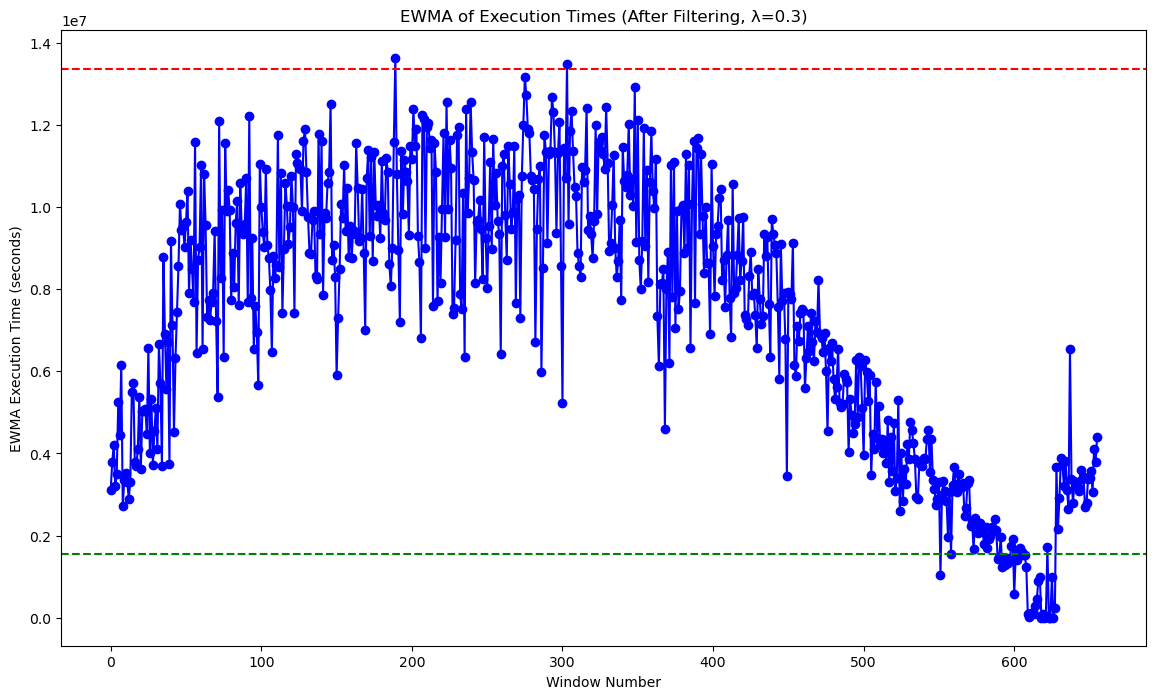

In [6]:
#CL 90
import pandas as pd
import matplotlib.pyplot as plt

# 设置 EWMA 平滑因子
lambda_ewma = 0.3

# 定义 EWMA 计算函数
def calculate_ewma(execution_times, lambda_ewma):
    ewma_values = []
    prev_ewma = execution_times[0]  # 使用第一个值初始化 EWMA
    for i in range(len(execution_times)):
        ewma = lambda_ewma * execution_times[i] + (1 - lambda_ewma) * prev_ewma
        ewma_values.append(ewma)
        prev_ewma = ewma
    return ewma_values

# Step 1: 计算每 10-case 窗口的 EWMA 值（过滤前数据）
execution_time_before_filter = df.groupby('case:concept:name').apply(
    lambda x: (x['Complete Timestamp'].max() - x['Complete Timestamp'].min()).total_seconds()
).reset_index(name='Execution Time')

window_size = 10
execution_time_before_filter['Window Number'] = execution_time_before_filter.index // window_size
ewma_results_before_filter = []

for _, window_data in execution_time_before_filter.groupby('Window Number'):
    ewma_values = calculate_ewma(window_data['Execution Time'].values, lambda_ewma)
    ewma_results_before_filter.extend(ewma_values)

execution_time_before_filter['EWMA'] = ewma_results_before_filter

# Step 2: 标记不稳定窗口（过滤前数据）
mean_ewma_before_filter = execution_time_before_filter['EWMA'].mean()
std_ewma_before_filter = execution_time_before_filter['EWMA'].std()
UCL_ewma_before_filter = mean_ewma_before_filter + 3 * std_ewma_before_filter
LCL_ewma_before_filter = max(mean_ewma_before_filter - 3 * std_ewma_before_filter, 0)

execution_time_before_filter['Out of Control'] = (execution_time_before_filter['EWMA'] > UCL_ewma_before_filter) | \
                                                 (execution_time_before_filter['EWMA'] < LCL_ewma_before_filter)

unstable_windows_before_filter = execution_time_before_filter.groupby('Window Number')['Out of Control'].any().sum()
stable_windows_before_filter = execution_time_before_filter['Window Number'].nunique() - unstable_windows_before_filter
stability_score_before_filter = stable_windows_before_filter / execution_time_before_filter['Window Number'].nunique()


# 绘制过滤前的 EWMA 图，只显示每个窗口的最后一个EWMA值
window_last_ewma = execution_time_before_filter.groupby('Window Number')['EWMA'].last()  # 获取每个窗口的最后一个EWMA值



# Step 1: 过滤掉执行时间为 0 的数据
execution_time_after_filter = execution_time_before_filter[execution_time_before_filter['Execution Time'] > 0]

# Step 2: 重新计算 EWMA 值（过滤后数据）
execution_time_after_filter['Window Number'] = execution_time_after_filter.index // window_size
ewma_results_after_filter = []

for _, window_data in execution_time_after_filter.groupby('Window Number'):
    ewma_values = calculate_ewma(window_data['Execution Time'].values, lambda_ewma)
    ewma_results_after_filter.extend(ewma_values)

execution_time_after_filter['EWMA'] = ewma_results_after_filter

# Step 3: 标记不稳定窗口（过滤后数据） using 90% CL (1.645 * std)
mean_ewma_after_filter = execution_time_after_filter['EWMA'].mean()
std_ewma_after_filter = execution_time_after_filter['EWMA'].std()
UCL_ewma_after_filter = mean_ewma_after_filter + 1.645 * std_ewma_after_filter  # 90% CL
LCL_ewma_after_filter = max(mean_ewma_after_filter - 1.645 * std_ewma_after_filter, 0)  # 90% CL

execution_time_after_filter['Out of Control'] = (execution_time_after_filter['EWMA'] > UCL_ewma_after_filter) | \
                                                (execution_time_after_filter['EWMA'] < LCL_ewma_after_filter)

unstable_windows_after_filter = execution_time_after_filter.groupby('Window Number')['Out of Control'].any().sum()
stable_windows_after_filter = execution_time_after_filter['Window Number'].nunique() - unstable_windows_after_filter
stability_score_after_filter = stable_windows_after_filter / execution_time_after_filter['Window Number'].nunique()

print(f"After Filtering - Stability Score: {stability_score_after_filter:.2%}")
print(f"After Filtering - Unstable Windows: {unstable_windows_after_filter}")
print(f"After Filtering - Stable Windows: {stable_windows_after_filter}")
# 绘制过滤后的 EWMA 图，只显示每个窗口的最后一个EWMA值
window_last_ewma_after_filter = execution_time_after_filter.groupby('Window Number')['EWMA'].last()  # 获取每个窗口的最后一个EWMA值

plt.figure(figsize=(14, 8))
plt.plot(window_last_ewma_after_filter.index, window_last_ewma_after_filter, marker='o', linestyle='-', color='blue')  # 使用每个窗口的最后一个EWMA值
plt.axhline(UCL_ewma_after_filter, color='red', linestyle='--')
plt.axhline(LCL_ewma_after_filter, color='green', linestyle='--')
plt.title(f'EWMA of Execution Times (After Filtering, λ={lambda_ewma})')
plt.xlabel('Window Number')  # X轴改为显示窗口号
plt.ylabel('EWMA Execution Time (seconds)')
plt.legend([], frameon=False)
plt.show()

Before Filtering - Total Windows: 656
Before Filtering - Stable Windows: 653
Before Filtering - Stability Score: 99.54%
After Filtering - Total Windows: 656
After Filtering - Stable Windows: 653
After Filtering - Stability Score: 99.54%


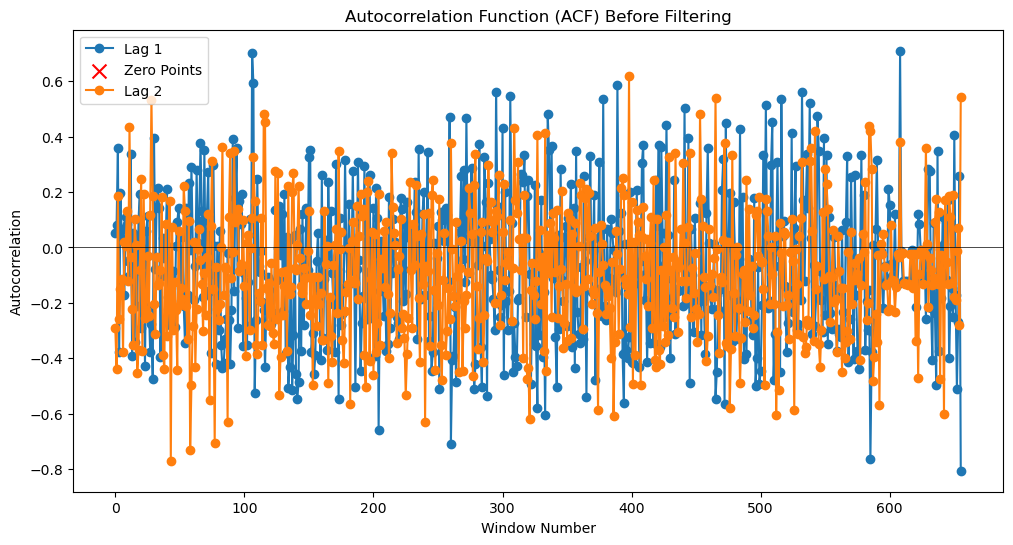

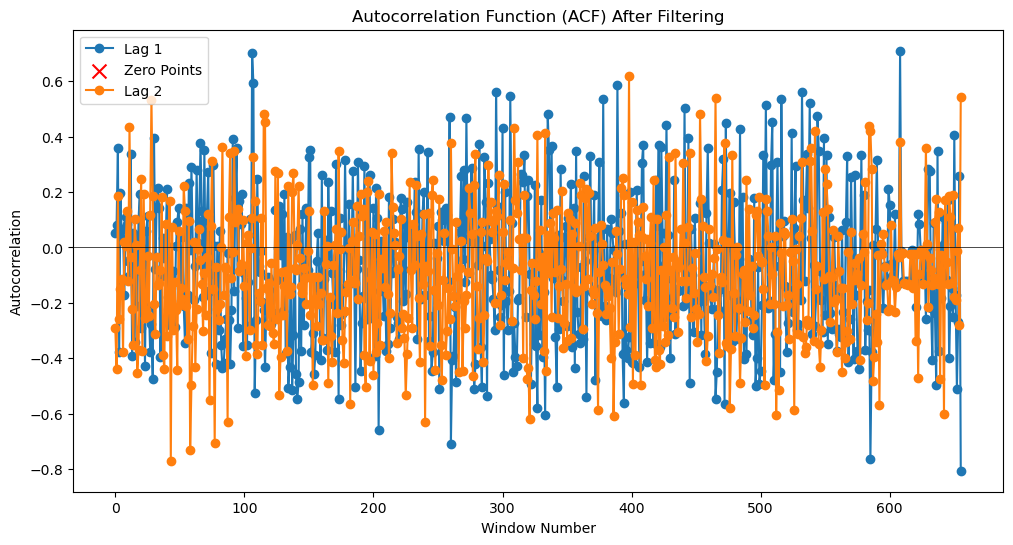

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 计算自相关函数（ACF）
def calculate_autocorrelation(y, lag):
    mean_y = np.mean(y)
    numerator = np.sum((y[lag:] - mean_y) * (y[:-lag] - mean_y))
    denominator = np.sum((y - mean_y) ** 2)
    return numerator / denominator

# 自相关的滞后值
lags = [1, 2]  # 可以根据需要指定更多的滞后值

# 计算过滤前的数据自相关（ACF）结果
window_acf_results_before = {}

for window_num, window_data in execution_time_before_filter.groupby('Window Number'):
    y = window_data['Execution Time'].values
    acf_values = {}
    for lag in lags:
        if len(y) > lag:  # 确保滞后值不超过数据点数量
            acf_values[f'Lag {lag}'] = calculate_autocorrelation(y, lag)
        else:
            acf_values[f'Lag {lag}'] = np.nan  # 数据不足时返回 NaN
    window_acf_results_before[window_num] = acf_values

# 转换为 DataFrame，便于分析和绘图
acf_df_before = pd.DataFrame(window_acf_results_before).T
acf_df_before.columns = [f'Lag {lag}' for lag in lags]

# 计算过滤后的数据自相关（ACF）结果
window_acf_results_after = {}

for window_num, window_data in execution_time_after_filter.groupby('Window Number'):
    y = window_data['Execution Time'].values
    acf_values = {}
    for lag in lags:
        if len(y) > lag:  # 确保滞后值不超过数据点数量
            acf_values[f'Lag {lag}'] = calculate_autocorrelation(y, lag)
        else:
            acf_values[f'Lag {lag}'] = np.nan  # 数据不足时返回 NaN
    window_acf_results_after[window_num] = acf_values

# 转换为 DataFrame，便于分析和绘图
acf_df_after = pd.DataFrame(window_acf_results_after).T
acf_df_after.columns = [f'Lag {lag}' for lag in lags]

# 计算并评估每个窗口的稳定性：根据自相关值和置信区间评估窗口稳定性
def calculate_stability(acf_df, N):
    stability_results = []
    standard_error = 1 / (N**0.5)  # 计算标准误差
    confidence_interval = 2 * standard_error  # 置信区间 ±2 标准误差

    for index, row in acf_df.iterrows():
        # 检查每个滞后值的自相关值是否在置信区间内
        is_stable = all(abs(value) < confidence_interval for value in row[1:])  # 排除第一列（索引）
        stability_results.append(is_stable)

    stable_windows_count = sum(stability_results)
    total_windows_count = len(stability_results)
    stability_score = (stable_windows_count / total_windows_count) * 100

    return stable_windows_count, total_windows_count, stability_score

# 设置每个窗口的观察值数量（N）
N = 10

# 计算过滤前后的稳定性
stable_windows_before, total_windows_before, stability_score_before = calculate_stability(acf_df_before, N)
stable_windows_after, total_windows_after, stability_score_after = calculate_stability(acf_df_after, N)

# 打印结果
print(f"Before Filtering - Total Windows: {total_windows_before}")
print(f"Before Filtering - Stable Windows: {stable_windows_before}")
print(f"Before Filtering - Stability Score: {stability_score_before:.2f}%")

print(f"After Filtering - Total Windows: {total_windows_after}")
print(f"After Filtering - Stable Windows: {stable_windows_after}")
print(f"After Filtering - Stability Score: {stability_score_after:.2f}%")

# 绘制过滤前后的自相关图
def plot_acf(acf_df, title):
    plt.figure(figsize=(12, 6))

    for lag in lags:
        acf_values = acf_df[f'Lag {lag}'].copy()
        
        # 替换自相关值为0的点为NaN，以在绘图时产生断点
        acf_values[acf_values == 0] = np.nan  
        
        # 绘制自相关值
        plt.plot(acf_df.index, acf_values, marker='o', label=f'Lag {lag}')
        
        # 在0值的位置添加标记
        zero_positions = acf_df.index[acf_df[f'Lag {lag}'] == 0]
        plt.scatter(zero_positions, np.zeros_like(zero_positions), color='red', marker='x', s=100, label='Zero Points' if lag == lags[0] else "")
    
    plt.axhline(0, color='black', linewidth=0.5)  # 添加0参考线
    plt.title(title)
    plt.xlabel('Window Number')
    plt.ylabel('Autocorrelation')
    plt.legend()
    plt.show()

# 绘制过滤前后的自相关图
plot_acf(acf_df_before, 'Autocorrelation Function (ACF) Before Filtering')
plot_acf(acf_df_after, 'Autocorrelation Function (ACF) After Filtering')

Before Filtering - Total Windows: 656
Before Filtering - Stable Windows: 649
Before Filtering - Stability Score: 98.93%
After Filtering - Total Windows: 656
After Filtering - Stable Windows: 649
After Filtering - Stability Score: 98.93%


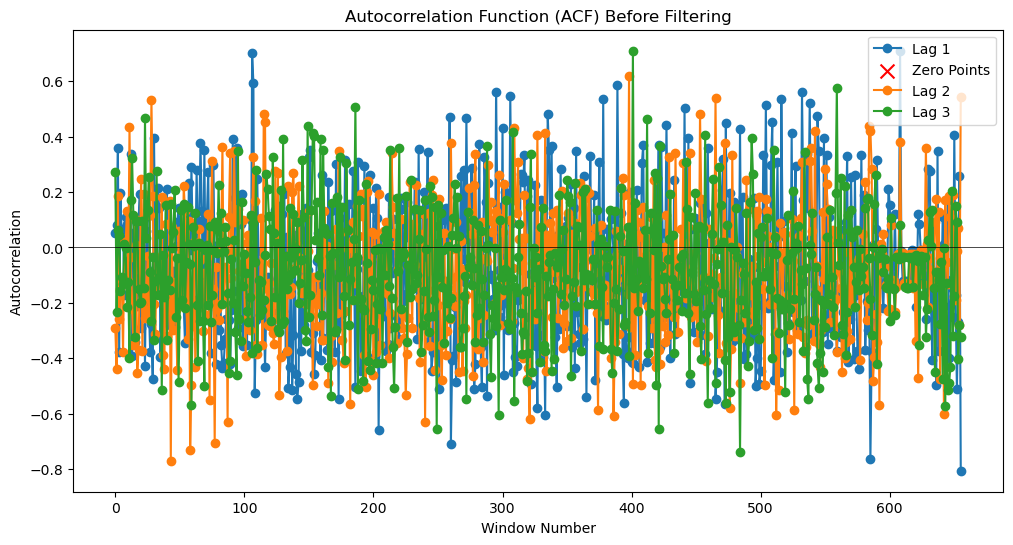

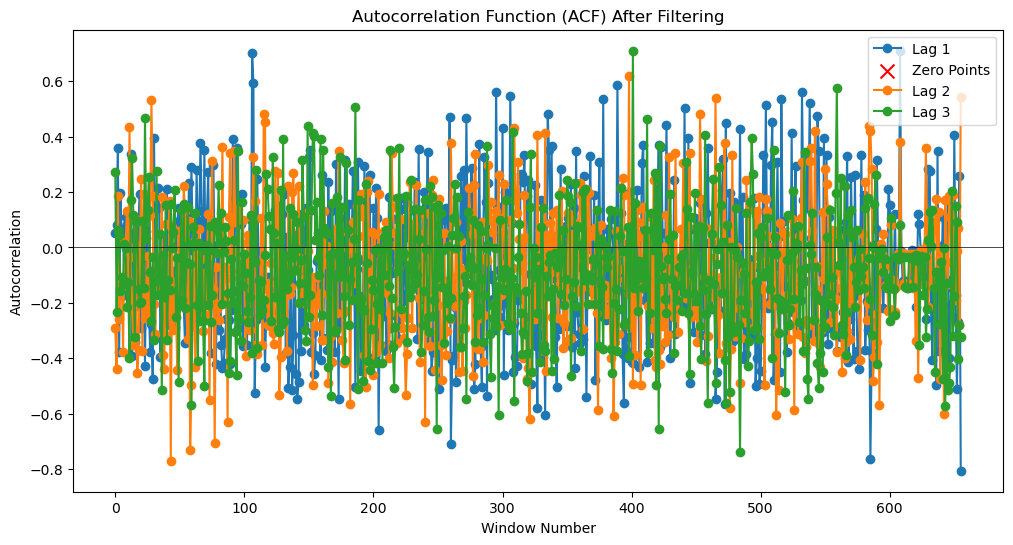

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 计算自相关函数（ACF）
def calculate_autocorrelation(y, lag):
    mean_y = np.mean(y)
    numerator = np.sum((y[lag:] - mean_y) * (y[:-lag] - mean_y))
    denominator = np.sum((y - mean_y) ** 2)
    return numerator / denominator

# 自相关的滞后值
lags = [1, 2, 3]  # 可以根据需要指定更多的滞后值

# 计算过滤前的数据自相关（ACF）结果
window_acf_results_before = {}

for window_num, window_data in execution_time_before_filter.groupby('Window Number'):
    y = window_data['Execution Time'].values
    acf_values = {}
    for lag in lags:
        if len(y) > lag:  # 确保滞后值不超过数据点数量
            acf_values[f'Lag {lag}'] = calculate_autocorrelation(y, lag)
        else:
            acf_values[f'Lag {lag}'] = np.nan  # 数据不足时返回 NaN
    window_acf_results_before[window_num] = acf_values

# 转换为 DataFrame，便于分析和绘图
acf_df_before = pd.DataFrame(window_acf_results_before).T
acf_df_before.columns = [f'Lag {lag}' for lag in lags]

# 计算过滤后的数据自相关（ACF）结果
window_acf_results_after = {}

for window_num, window_data in execution_time_after_filter.groupby('Window Number'):
    y = window_data['Execution Time'].values
    acf_values = {}
    for lag in lags:
        if len(y) > lag:  # 确保滞后值不超过数据点数量
            acf_values[f'Lag {lag}'] = calculate_autocorrelation(y, lag)
        else:
            acf_values[f'Lag {lag}'] = np.nan  # 数据不足时返回 NaN
    window_acf_results_after[window_num] = acf_values

# 转换为 DataFrame，便于分析和绘图
acf_df_after = pd.DataFrame(window_acf_results_after).T
acf_df_after.columns = [f'Lag {lag}' for lag in lags]

# 计算并评估每个窗口的稳定性：根据自相关值和置信区间评估窗口稳定性
def calculate_stability(acf_df, N):
    stability_results = []
    standard_error = 1 / (N**0.5)  # 计算标准误差
    confidence_interval = 2 * standard_error  # 置信区间 ±2 标准误差

    for index, row in acf_df.iterrows():
        # 检查每个滞后值的自相关值是否在置信区间内
        is_stable = all(abs(value) < confidence_interval for value in row[1:])  # 排除第一列（索引）
        stability_results.append(is_stable)

    stable_windows_count = sum(stability_results)
    total_windows_count = len(stability_results)
    stability_score = (stable_windows_count / total_windows_count) * 100

    return stable_windows_count, total_windows_count, stability_score

# 设置每个窗口的观察值数量（N）
N = 10

# 计算过滤前后的稳定性
stable_windows_before, total_windows_before, stability_score_before = calculate_stability(acf_df_before, N)
stable_windows_after, total_windows_after, stability_score_after = calculate_stability(acf_df_after, N)

# 打印结果
print(f"Before Filtering - Total Windows: {total_windows_before}")
print(f"Before Filtering - Stable Windows: {stable_windows_before}")
print(f"Before Filtering - Stability Score: {stability_score_before:.2f}%")

print(f"After Filtering - Total Windows: {total_windows_after}")
print(f"After Filtering - Stable Windows: {stable_windows_after}")
print(f"After Filtering - Stability Score: {stability_score_after:.2f}%")

# 绘制过滤前后的自相关图
def plot_acf(acf_df, title):
    plt.figure(figsize=(12, 6))

    for lag in lags:
        acf_values = acf_df[f'Lag {lag}'].copy()
        
        # 替换自相关值为0的点为NaN，以在绘图时产生断点
        acf_values[acf_values == 0] = np.nan  
        
        # 绘制自相关值
        plt.plot(acf_df.index, acf_values, marker='o', label=f'Lag {lag}')
        
        # 在0值的位置添加标记
        zero_positions = acf_df.index[acf_df[f'Lag {lag}'] == 0]
        plt.scatter(zero_positions, np.zeros_like(zero_positions), color='red', marker='x', s=100, label='Zero Points' if lag == lags[0] else "")
    
    plt.axhline(0, color='black', linewidth=0.5)  # 添加0参考线
    plt.title(title)
    plt.xlabel('Window Number')
    plt.ylabel('Autocorrelation')
    plt.legend()
    plt.show()

# 绘制过滤前后的自相关图
plot_acf(acf_df_before, 'Autocorrelation Function (ACF) Before Filtering')
plot_acf(acf_df_after, 'Autocorrelation Function (ACF) After Filtering')

Before Filtering - Total Windows: 656
Before Filtering - Stable Windows: 648
Before Filtering - Stability Score: 98.78%
After Filtering - Total Windows: 656
After Filtering - Stable Windows: 648
After Filtering - Stability Score: 98.78%


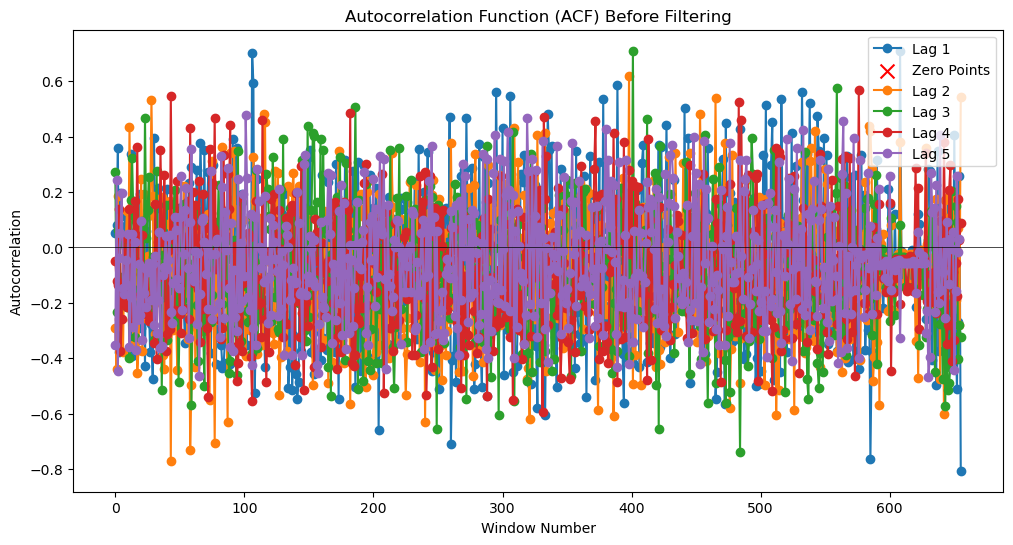

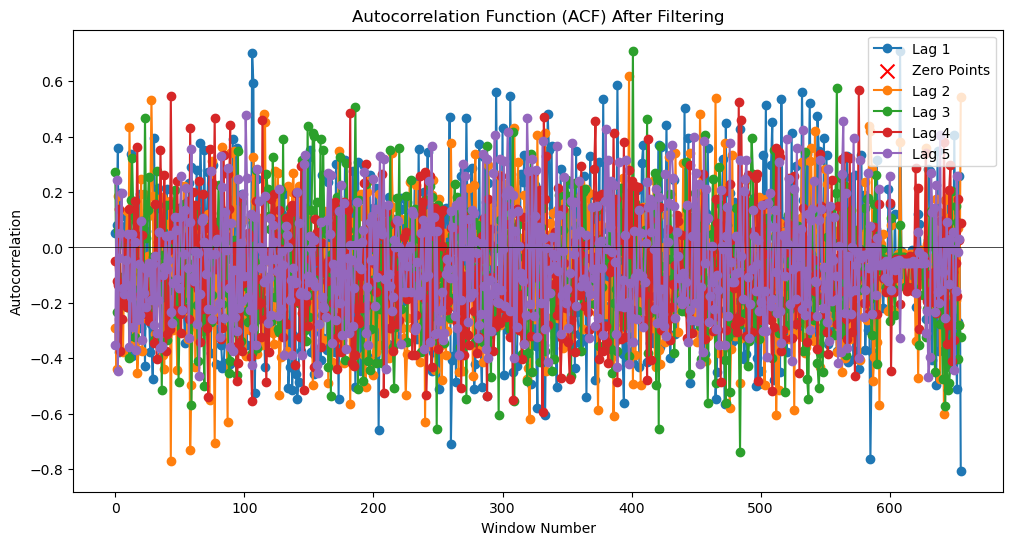

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 计算自相关函数（ACF）
def calculate_autocorrelation(y, lag):
    mean_y = np.mean(y)
    numerator = np.sum((y[lag:] - mean_y) * (y[:-lag] - mean_y))
    denominator = np.sum((y - mean_y) ** 2)
    return numerator / denominator

# 自相关的滞后值
lags = [1, 2, 3, 4, 5]  # 可以根据需要指定更多的滞后值

# 计算过滤前的数据自相关（ACF）结果
window_acf_results_before = {}

for window_num, window_data in execution_time_before_filter.groupby('Window Number'):
    y = window_data['Execution Time'].values
    acf_values = {}
    for lag in lags:
        if len(y) > lag:  # 确保滞后值不超过数据点数量
            acf_values[f'Lag {lag}'] = calculate_autocorrelation(y, lag)
        else:
            acf_values[f'Lag {lag}'] = np.nan  # 数据不足时返回 NaN
    window_acf_results_before[window_num] = acf_values

# 转换为 DataFrame，便于分析和绘图
acf_df_before = pd.DataFrame(window_acf_results_before).T
acf_df_before.columns = [f'Lag {lag}' for lag in lags]

# 计算过滤后的数据自相关（ACF）结果
window_acf_results_after = {}

for window_num, window_data in execution_time_after_filter.groupby('Window Number'):
    y = window_data['Execution Time'].values
    acf_values = {}
    for lag in lags:
        if len(y) > lag:  # 确保滞后值不超过数据点数量
            acf_values[f'Lag {lag}'] = calculate_autocorrelation(y, lag)
        else:
            acf_values[f'Lag {lag}'] = np.nan  # 数据不足时返回 NaN
    window_acf_results_after[window_num] = acf_values

# 转换为 DataFrame，便于分析和绘图
acf_df_after = pd.DataFrame(window_acf_results_after).T
acf_df_after.columns = [f'Lag {lag}' for lag in lags]

# 计算并评估每个窗口的稳定性：根据自相关值和置信区间评估窗口稳定性
def calculate_stability(acf_df, N):
    stability_results = []
    standard_error = 1 / (N**0.5)  # 计算标准误差
    confidence_interval = 2 * standard_error  # 置信区间 ±2 标准误差

    for index, row in acf_df.iterrows():
        # 检查每个滞后值的自相关值是否在置信区间内
        is_stable = all(abs(value) < confidence_interval for value in row[1:])  # 排除第一列（索引）
        stability_results.append(is_stable)

    stable_windows_count = sum(stability_results)
    total_windows_count = len(stability_results)
    stability_score = (stable_windows_count / total_windows_count) * 100

    return stable_windows_count, total_windows_count, stability_score

# 设置每个窗口的观察值数量（N）
N = 10

# 计算过滤前后的稳定性
stable_windows_before, total_windows_before, stability_score_before = calculate_stability(acf_df_before, N)
stable_windows_after, total_windows_after, stability_score_after = calculate_stability(acf_df_after, N)

# 打印结果
print(f"Before Filtering - Total Windows: {total_windows_before}")
print(f"Before Filtering - Stable Windows: {stable_windows_before}")
print(f"Before Filtering - Stability Score: {stability_score_before:.2f}%")

print(f"After Filtering - Total Windows: {total_windows_after}")
print(f"After Filtering - Stable Windows: {stable_windows_after}")
print(f"After Filtering - Stability Score: {stability_score_after:.2f}%")

# 绘制过滤前后的自相关图
def plot_acf(acf_df, title):
    plt.figure(figsize=(12, 6))

    for lag in lags:
        acf_values = acf_df[f'Lag {lag}'].copy()
        
        # 替换自相关值为0的点为NaN，以在绘图时产生断点
        acf_values[acf_values == 0] = np.nan  
        
        # 绘制自相关值
        plt.plot(acf_df.index, acf_values, marker='o', label=f'Lag {lag}')
        
        # 在0值的位置添加标记
        zero_positions = acf_df.index[acf_df[f'Lag {lag}'] == 0]
        plt.scatter(zero_positions, np.zeros_like(zero_positions), color='red', marker='x', s=100, label='Zero Points' if lag == lags[0] else "")
    
    plt.axhline(0, color='black', linewidth=0.5)  # 添加0参考线
    plt.title(title)
    plt.xlabel('Window Number')
    plt.ylabel('Autocorrelation')
    plt.legend()
    plt.show()

# 绘制过滤前后的自相关图
plot_acf(acf_df_before, 'Autocorrelation Function (ACF) Before Filtering')
plot_acf(acf_df_after, 'Autocorrelation Function (ACF) After Filtering')

Before Filtering - Total Windows: 656
Before Filtering - Stable Windows: 620
Before Filtering - Stability Score: 94.51%
After Filtering - Total Windows: 656
After Filtering - Stable Windows: 620
After Filtering - Stability Score: 94.51%


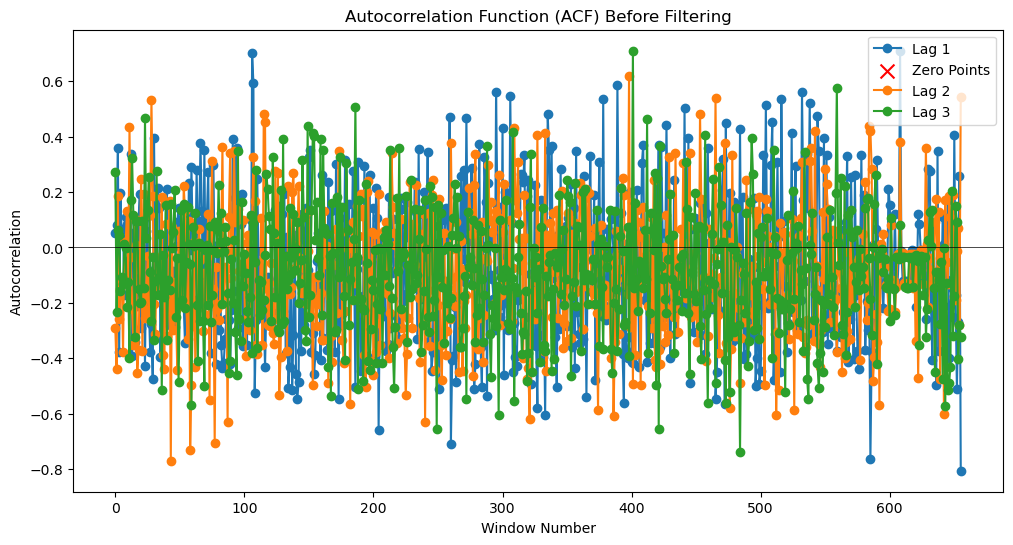

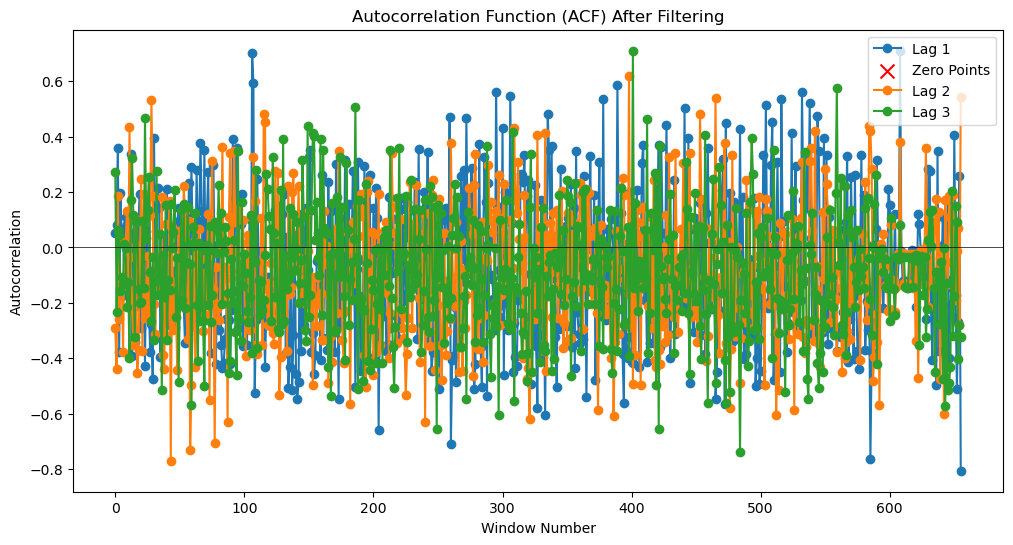

In [10]:
# 90CL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculate autocorrelation function (ACF)
def calculate_autocorrelation(y, lag):
    mean_y = np.mean(y)
    numerator = np.sum((y[lag:] - mean_y) * (y[:-lag] - mean_y))
    denominator = np.sum((y - mean_y) ** 2)
    return numerator / denominator

# Autocorrelation lags
lags = [1, 2, 3]  # Specify more lags if needed

# Calculate autocorrelation (ACF) results before filtering
window_acf_results_before = {}

for window_num, window_data in execution_time_before_filter.groupby('Window Number'):
    y = window_data['Execution Time'].values
    acf_values = {}
    for lag in lags:
        if len(y) > lag:  # Ensure the lag is not greater than the number of data points
            acf_values[f'Lag {lag}'] = calculate_autocorrelation(y, lag)
        else:
            acf_values[f'Lag {lag}'] = np.nan  # Return NaN if not enough data
    window_acf_results_before[window_num] = acf_values

# Convert to DataFrame for analysis and plotting
acf_df_before = pd.DataFrame(window_acf_results_before).T
acf_df_before.columns = [f'Lag {lag}' for lag in lags]

# Calculate autocorrelation (ACF) results after filtering
window_acf_results_after = {}

for window_num, window_data in execution_time_after_filter.groupby('Window Number'):
    y = window_data['Execution Time'].values
    acf_values = {}
    for lag in lags:
        if len(y) > lag:  # Ensure the lag is not greater than the number of data points
            acf_values[f'Lag {lag}'] = calculate_autocorrelation(y, lag)
        else:
            acf_values[f'Lag {lag}'] = np.nan  # Return NaN if not enough data
    window_acf_results_after[window_num] = acf_values

# Convert to DataFrame for analysis and plotting
acf_df_after = pd.DataFrame(window_acf_results_after).T
acf_df_after.columns = [f'Lag {lag}' for lag in lags]

# Calculate and evaluate stability of each window based on autocorrelation and the 90% confidence level
def calculate_stability(acf_df, N):
    stability_results = []
    z_score_90 = 1.645  # Z-score for 90% confidence interval
    standard_error = 1 / (N**0.5)  # Calculate standard error
    confidence_interval = z_score_90 * standard_error  # 90% confidence interval

    for index, row in acf_df.iterrows():
        # Check if all autocorrelation values are within the confidence interval for stability
        is_stable = all(abs(value) < confidence_interval for value in row[1:])  # Skip the index column
        stability_results.append(is_stable)

    stable_windows_count = sum(stability_results)
    total_windows_count = len(stability_results)
    stability_score = (stable_windows_count / total_windows_count) * 100

    return stable_windows_count, total_windows_count, stability_score

# Set the number of observations per window (N)
N = 10

# Calculate stability before and after filtering
stable_windows_before, total_windows_before, stability_score_before = calculate_stability(acf_df_before, N)
stable_windows_after, total_windows_after, stability_score_after = calculate_stability(acf_df_after, N)

# Print results
print(f"Before Filtering - Total Windows: {total_windows_before}")
print(f"Before Filtering - Stable Windows: {stable_windows_before}")
print(f"Before Filtering - Stability Score: {stability_score_before:.2f}%")

print(f"After Filtering - Total Windows: {total_windows_after}")
print(f"After Filtering - Stable Windows: {stable_windows_after}")
print(f"After Filtering - Stability Score: {stability_score_after:.2f}%")

# Plot the autocorrelation function before and after filtering
def plot_acf(acf_df, title):
    plt.figure(figsize=(12, 6))

    for lag in lags:
        acf_values = acf_df[f'Lag {lag}'].copy()
        
        # Replace autocorrelation values of 0 with NaN for gaps in the plot
        acf_values[acf_values == 0] = np.nan  
        
        # Plot the autocorrelation values
        plt.plot(acf_df.index, acf_values, marker='o', label=f'Lag {lag}')
        
        # Mark positions where the autocorrelation is 0
        zero_positions = acf_df.index[acf_df[f'Lag {lag}'] == 0]
        plt.scatter(zero_positions, np.zeros_like(zero_positions), color='red', marker='x', s=100, label='Zero Points' if lag == lags[0] else "")
    
    plt.axhline(0, color='black', linewidth=0.5)  # Add the 0 reference line
    plt.title(title)
    plt.xlabel('Window Number')
    plt.ylabel('Autocorrelation')
    plt.legend()
    plt.show()

# Plot the autocorrelation function before and after filtering
plot_acf(acf_df_before, 'Autocorrelation Function (ACF) Before Filtering')
plot_acf(acf_df_after, 'Autocorrelation Function (ACF) After Filtering')


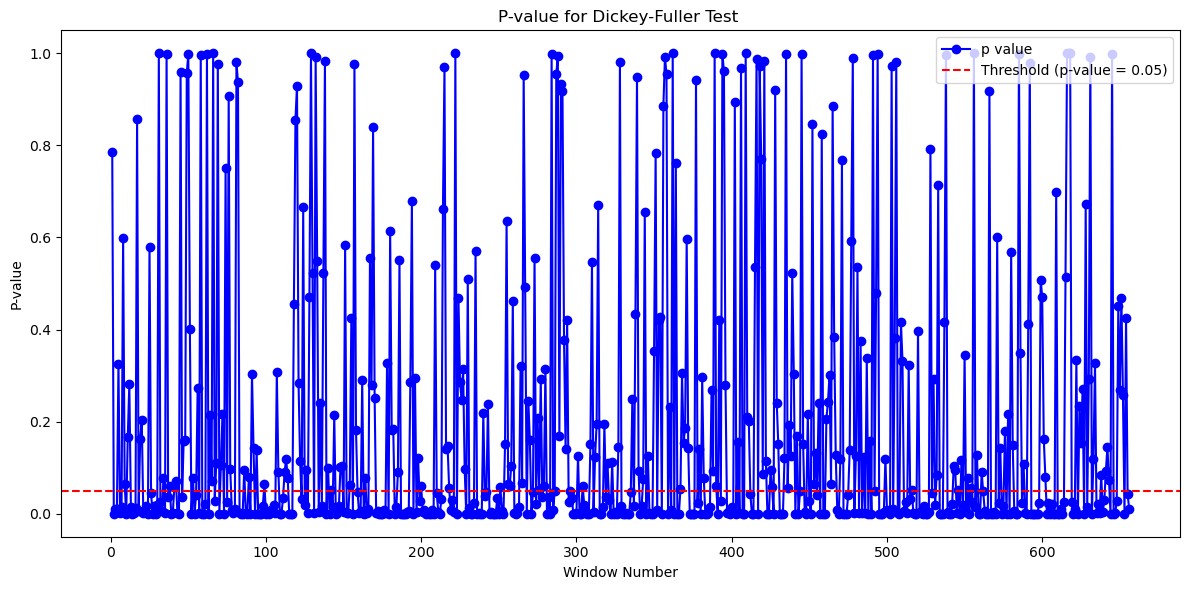

Stability Rate Before Filtering: 0.62
Stability Rate After Filtering: 0.62


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Function to decompose the window data
def decompose_window(window_data):
    """Decompose the window data into trend and residual components using a moving average."""
    if 'Execution Time' not in window_data.columns:
        return None
    
    execution_time_series = window_data['Execution Time']
    
    # Ensure data is not empty
    if len(execution_time_series) < 2:
        return None
    
    # Apply a simple moving average (for trend)
    moving_average = execution_time_series.rolling(window=3, min_periods=1).mean()
    
    # Calculate residuals (difference between original data and the moving average)
    residuals = execution_time_series - moving_average
    return residuals

# Perform the Dickey-Fuller test
def dickey_fuller_test(residuals):
    """Perform the Dickey-Fuller test on residuals and return the p-value."""
    result = adfuller(residuals.dropna())  # Perform ADF test, drop NaN values from residuals
    return result[1]  # p-value is the second item in the result tuple

# Initialize lists to hold p-values for before and after filtering
p_values_before = []
p_values_after = []

# Loop for 'before filtering' data
for window_num, window_data in execution_time_before_filter.groupby('Window Number'):
    # Decompose the window data and get residuals
    residuals = decompose_window(window_data)
    
    if residuals is not None:
        # Perform the Dickey-Fuller test on the residuals
        p_value = dickey_fuller_test(residuals)
        p_values_before.append(p_value)

# Loop for 'after filtering' data
for window_num, window_data in execution_time_after_filter.groupby('Window Number'):
    # Decompose the window data and get residuals
    residuals = decompose_window(window_data)
    
    if residuals is not None:
        # Perform the Dickey-Fuller test on the residuals
        p_value = dickey_fuller_test(residuals)
        p_values_after.append(p_value)

# Plotting the p-values for both before and after filtering
def plot_p_values(p_values_before, p_values_after, threshold=0.05):
    """This function plots p-values for each window before and after filtering."""
    windows_before = list(range(1, len(p_values_before) + 1))
    windows_after = list(range(1, len(p_values_after) + 1))

    # Create a new figure
    plt.figure(figsize=(12, 6))
    
    # Plot p-values before filtering
    plt.plot(windows_before, p_values_before, marker='o', color='blue', label='p value', linestyle='-', markersize=6)
    
    
    # Plot threshold line
    plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold (p-value = 0.05)')
    
    # Add labels and title
    plt.xlabel('Window Number')
    plt.ylabel('P-value')
    plt.title('P-value for Dickey-Fuller Test ')
    
    # Show legend
    plt.legend(loc='upper right')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_p_values(p_values_before, p_values_after)
# Function to calculate the stability rate
def calculate_stability_rate(p_values, threshold=0.1):
    """Calculate the stability rate based on p-values."""
    stable_windows = [p for p in p_values if p < threshold]
    stability_rate = len(stable_windows) / len(p_values) if len(p_values) > 0 else 0
    return stability_rate

# Calculate stability rate before filtering
stability_rate_before = calculate_stability_rate(p_values_before, threshold=0.1)
print(f"Stability Rate Before Filtering: {stability_rate_before:.2f}")

# Calculate stability rate after filtering
stability_rate_after = calculate_stability_rate(p_values_after, threshold=0.1)
print(f"Stability Rate After Filtering: {stability_rate_after:.2f}")

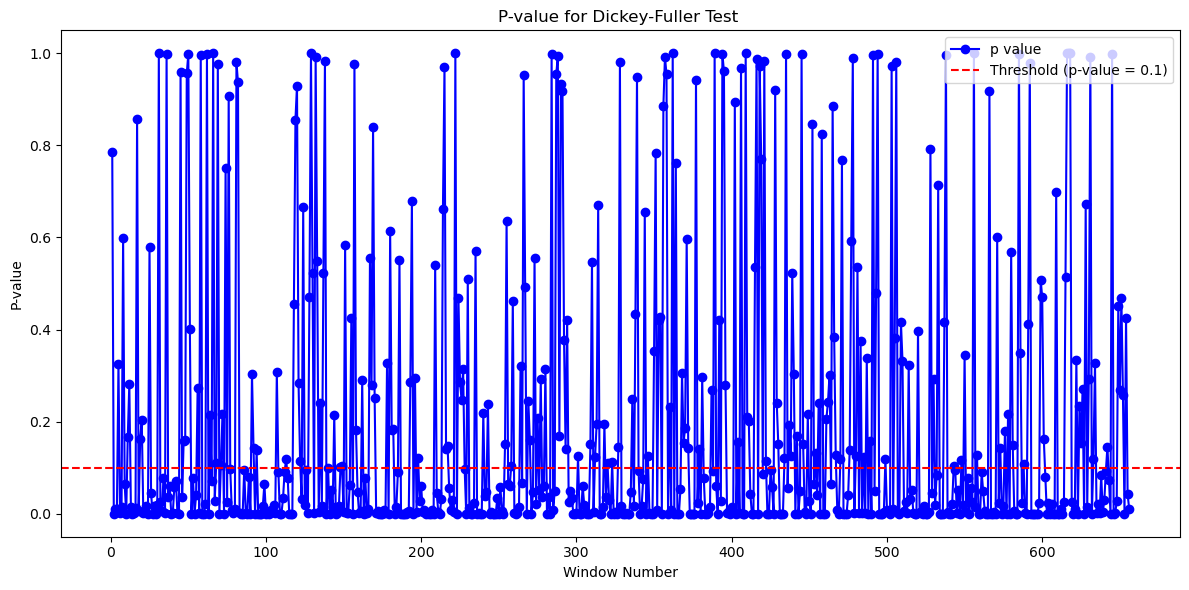

Stability Rate Before Filtering: 0.62
Stability Rate After Filtering: 0.62


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

# Function to decompose the window data
def decompose_window(window_data):
    """Decompose the window data into trend and residual components using a moving average."""
    if 'Execution Time' not in window_data.columns:
        return None
    
    execution_time_series = window_data['Execution Time']
    
    # Ensure data is not empty
    if len(execution_time_series) < 2:
        return None
    
    # Apply a simple moving average (for trend)
    moving_average = execution_time_series.rolling(window=3, min_periods=1).mean()
    
    # Calculate residuals (difference between original data and the moving average)
    residuals = execution_time_series - moving_average
    return residuals

# Perform the Dickey-Fuller test
def dickey_fuller_test(residuals):
    """Perform the Dickey-Fuller test on residuals and return the p-value."""
    result = adfuller(residuals.dropna())  # Perform ADF test, drop NaN values from residuals
    return result[1]  # p-value is the second item in the result tuple

# Initialize lists to hold p-values for before and after filtering
p_values_before = []
p_values_after = []

# Loop for 'before filtering' data
for window_num, window_data in execution_time_before_filter.groupby('Window Number'):
    # Decompose the window data and get residuals
    residuals = decompose_window(window_data)
    
    if residuals is not None:
        # Perform the Dickey-Fuller test on the residuals
        p_value = dickey_fuller_test(residuals)
        p_values_before.append(p_value)

# Loop for 'after filtering' data
for window_num, window_data in execution_time_after_filter.groupby('Window Number'):
    # Decompose the window data and get residuals
    residuals = decompose_window(window_data)
    
    if residuals is not None:
        # Perform the Dickey-Fuller test on the residuals
        p_value = dickey_fuller_test(residuals)
        p_values_after.append(p_value)

# Plotting the p-values for both before and after filtering
def plot_p_values(p_values_before, p_values_after, threshold=0.1):
    """This function plots p-values for each window before and after filtering."""
    windows_before = list(range(1, len(p_values_before) + 1))
    windows_after = list(range(1, len(p_values_after) + 1))

    # Create a new figure
    plt.figure(figsize=(12, 6))
    
    # Plot p-values before filtering
    plt.plot(windows_before, p_values_before, marker='o', color='blue', label='p value', linestyle='-', markersize=6)
    
    
    # Plot threshold line
    plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold (p-value = 0.1)')
    
    # Add labels and title
    plt.xlabel('Window Number')
    plt.ylabel('P-value')
    plt.title('P-value for Dickey-Fuller Test ')
    
    # Show legend
    plt.legend(loc='upper right')
    
    # Display the plot
    plt.tight_layout()
    plt.show()

# Call the plotting function
plot_p_values(p_values_before, p_values_after)

# Function to calculate the stability rate
def calculate_stability_rate(p_values, threshold=0.1):
    """Calculate the stability rate based on p-values."""
    stable_windows = [p for p in p_values if p < threshold]
    stability_rate = len(stable_windows) / len(p_values) if len(p_values) > 0 else 0
    return stability_rate

# Calculate stability rate before filtering
stability_rate_before = calculate_stability_rate(p_values_before, threshold=0.1)
print(f"Stability Rate Before Filtering: {stability_rate_before:.2f}")

# Calculate stability rate after filtering
stability_rate_after = calculate_stability_rate(p_values_after, threshold=0.1)
print(f"Stability Rate After Filtering: {stability_rate_after:.2f}")

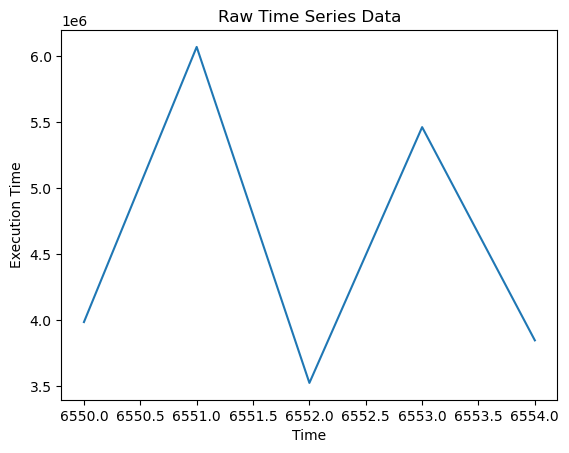

In [11]:
import matplotlib.pyplot as plt

# Plot the raw data
plt.plot(window_data['Execution Time'])
plt.title('Raw Time Series Data')
plt.xlabel('Time')
plt.ylabel('Execution Time')
plt.show()